Compute the efficiency of an FSGP 2024 lap by querying influx for required data and computing motor energy used.

1. input lap start, end, avg. speed from timing spreadsheet
2. query influx for time series data for motor current, pack voltage, regen_enabled
3. output efficiency in J/lap and j/m

In [1]:
from data_tools import DBClient, TimeSeries, FSGPDayLaps
import numpy as np
import matplotlib.pyplot as plt
import datetime

data_client = DBClient()

def calculate_lap_power(start_time: datetime, end_time: datetime, client: DBClient) -> TimeSeries:
    
    print(f"{start_time=}\n{end_time=}")
    
    motor_voltage: TimeSeries = client.query_time_series(start_time, end_time, "BatteryVoltage")
    raw_motor_current: TimeSeries = client.query_time_series(start_time, end_time, "BatteryCurrent")
    motor_current_dir: TimeSeries = client.query_time_series(start_time, end_time, "BatteryCurrentDirection")
    
    # Align x-axes
    raw_motor_current, motor_voltage, motor_current_dir = TimeSeries.align(raw_motor_current, motor_voltage, motor_current_dir)
    # Make direction -1 or 1 instead of 1 or 0
    motor_current_sign = motor_current_dir * -2 + 1
    
    # Account for regen direction
    motor_current = raw_motor_current.promote(raw_motor_current * motor_current_sign)
    motor_power = motor_current.promote(motor_current * motor_voltage)
    motor_power.units = "W"
    motor_power.meta["field"] = "Motor Power (adjusted for regen)"
    return motor_power

Creating client with API Token: s4Z9_S6_O09kDzYn1KZcs7LVoCA2cVK9_ObY44vR4xMh-wYLSWBkypS0S0ZHQgBvEV2A5LgvQ1IKr8byHes2LA==
Creating client with Org: 8a0b66d77a331e96


Now that we have obtained motor power, we can integrate to compute motor energy for the lap.

In [2]:
def calculate_lap_energy(start_time: datetime, end_time: datetime, client) -> TimeSeries:
    motor_power = calculate_lap_power(start_time, end_time, client)
    motor_energy = np.cumsum(motor_power) * motor_power.granularity
    motor_energy.units = "J"
    motor_energy.meta["field"] = "Motor Energy (regen adjusted)"
    return motor_energy

Now that we have the above functions., we can take compute the lap efficiency for any FSGP lap by using the FSGPDayLaps tool.

In [3]:
# Select which FSGP 2024 day to calculate lap efficiency for (1, 2 or 3)
laps1 = FSGPDayLaps(1)  # Corresponds to July 16th
laps3 = FSGPDayLaps(3)  # Corresponds to July 18th
day_1_idx = range(laps1.get_lap_count())
day_3_idx = range(laps3.get_lap_count())
num_laps = len(day_1_idx) + len(day_3_idx)

lap_energies = []
lap_drivers = []
lap_speeds = []

for day_laps, lap_indices in zip((laps1, laps3), (day_1_idx, day_3_idx)):
    for lap_idx in lap_indices:
        lap_num = lap_idx + 1
        
        lap_start = day_laps.get_start_utc(lap_num)
        lap_end = day_laps.get_finish_utc(lap_num)
        
        lap_energies.append(calculate_lap_energy(lap_start, lap_end, data_client))
        lap_drivers.append(day_laps.get_lap_driver(lap_num))
        lap_speeds.append(day_laps.get_lap_mph(lap_num))
        print(f"{len(lap_energies)=}", f"{lap_idx=}")
        print(f"Total motor energy for lap {lap_num}: {lap_energies[lap_idx][-1]}J\n"
              f"Average lap speed: {lap_speeds[lap_idx]} mph\n")

lap_energies = np.array([arr[-1] for arr in lap_energies])
lap_drivers = np.array(lap_drivers)
lap_speeds = np.array(lap_speeds)

start_time=datetime.datetime(2024, 7, 16, 15, 0, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 7, 4, tzinfo=datetime.timezone.utc)
len(lap_energies)=1 lap_idx=0
Total motor energy for lap 1: 846444.9264038402J
Average lap speed: 26.745 mph

start_time=datetime.datetime(2024, 7, 16, 15, 7, 4, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 13, 9, tzinfo=datetime.timezone.utc)
len(lap_energies)=2 lap_idx=1
Total motor energy for lap 2: 745938.7392217271J
Average lap speed: 31.068 mph

start_time=datetime.datetime(2024, 7, 16, 15, 13, 9, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 20, 19, tzinfo=datetime.timezone.utc)
len(lap_energies)=3 lap_idx=2
Total motor energy for lap 3: 624473.3598265548J
Average lap speed: 26.372 mph

start_time=datetime.datetime(2024, 7, 16, 15, 20, 19, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 27, 21, tzinfo=datetime.timezone.utc)
len(lap_energies)

We have now obtained the lap speeds and energies for all laps on `RACE_DAY`, and we can plot the resulting data.

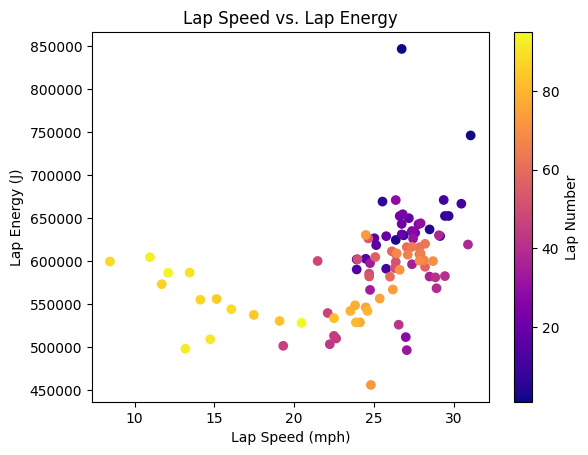

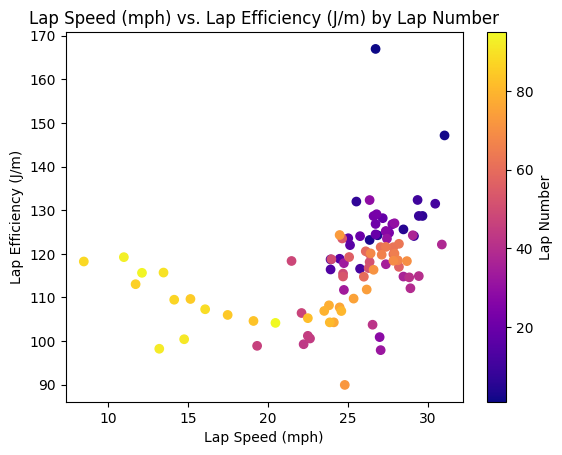

In [4]:
plt.scatter(lap_speeds, lap_energies, c=range(1, num_laps + 1), cmap='plasma', )

plt.xlabel("Lap Speed (mph)")
plt.ylabel("Lap Energy (J)")
plt.title(f"Lap Speed vs. Lap Energy")
plt.colorbar().set_label('Lap Number')
plt.show()

FSGP_TRACK_LEN_M = 5_070
lap_efficiencies = lap_energies / FSGP_TRACK_LEN_M

plt.scatter(lap_speeds, lap_efficiencies, c=range(1, num_laps + 1), cmap='plasma')
plt.xlabel("Lap Speed (mph)")
plt.ylabel("Lap Efficiency (J/m)")
plt.title(f"Lap Speed (mph) vs. Lap Efficiency (J/m) by Lap Number")
plt.colorbar().set_label('Lap Number')
plt.show()

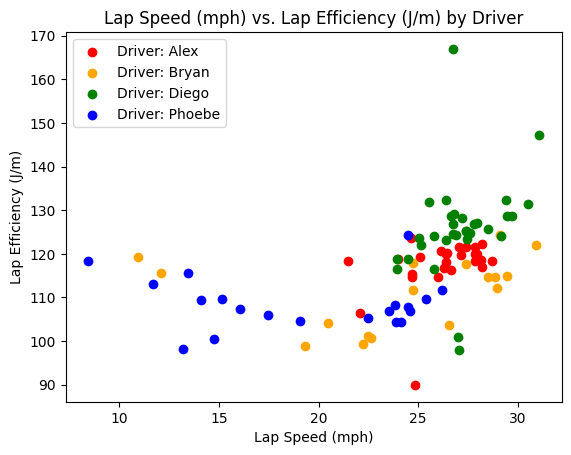

In [8]:
driver_colours = {
    "Alex": "red",
    "Bryan": "orange",
    "Diego": "green",
    "Phoebe": "blue"
}

for driver, colour in driver_colours.items():
    plt.scatter(lap_speeds[lap_drivers == driver],
                lap_efficiencies[lap_drivers == driver],
                c=colour,
                label=f"Driver: {driver}")
plt.xlabel("Lap Speed (mph)")
plt.ylabel("Lap Efficiency (J/m)")
plt.legend()
plt.title(f"Lap Speed (mph) vs. Lap Efficiency (J/m) by Driver")
plt.show()